In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions
from neurolib.experiments.WPtwo.onen.plot import plot_1n_osc, plot_1n_osc_noisy, set_labels

import matplotlib as mpl

set_labels()

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/1n")
dir = os.path.join(pickledir, "images_1n_wc")

print(dir)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/1n/images_1n_wc


In [2]:
w2_array_list = []

w2_array_list.append(1e-6 * np.arange(1.0, 11., 1.))
w2_array_list.append(1e-6 * np.arange(1.0, 11., 1.))
w2_array_list.append(1e-6 * np.arange(1.0, 11., 1.))
w2_array_list.append(1e-6 * np.arange(1.0, 11., 1.))

print(len(w2_array_list[0]))

10


In [3]:
data = dict()

p_names = ["A", "B", "C", "D"]
coords = [[1., 1., "A"], [1.7, 2., "B"], [3., 1., "C"], [4., 2., "D"]]

for i in range(len(p_names)):
    p = p_names[i]
    data[p] = dict()
    data[p]["coordinates"] = coords[i]
    data[p]["target_period"] = 25.
    data[p]["control"] = [None for x in range(len(w2_array_list[i]))]
    data[p]["state"] = [None for x in range(len(w2_array_list[i]))]
    data[p]["w2"] = w2_array_list[i].copy()

N = 1
model = WCModel()
print(data)

dt = model.params['dt']

{'A': {'coordinates': [1.0, 1.0, 'A'], 'target_period': 25.0, 'control': [None, None, None, None, None, None, None, None, None, None], 'state': [None, None, None, None, None, None, None, None, None, None], 'w2': array([1.e-06, 2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06,
       9.e-06, 1.e-05])}, 'B': {'coordinates': [1.7, 2.0, 'B'], 'target_period': 25.0, 'control': [None, None, None, None, None, None, None, None, None, None], 'state': [None, None, None, None, None, None, None, None, None, None], 'w2': array([1.e-06, 2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06,
       9.e-06, 1.e-05])}, 'C': {'coordinates': [3.0, 1.0, 'C'], 'target_period': 25.0, 'control': [None, None, None, None, None, None, None, None, None, None], 'state': [None, None, None, None, None, None, None, None, None, None], 'w2': array([1.e-06, 2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06,
       9.e-06, 1.e-05])}, 'D': {'coordinates': [4.0, 2.0, 'D'], 'target_period': 25.0, 'control': [No

In [4]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

duration = 200.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

it = 50
maxstr = 5
pr = np.arange(0,1001,50)
init_control = zero_control.copy()

Start with a small weight and increase itratively

In [107]:
for i in range(len(p_names)):
    if i not in [2]: continue
    print(i)
    p = p_names[i]
    print(data[p]["w2"][0])
    data[p]["w2"] *= 4./2.5
    print(data[p]["w2"][0])

2
0.0025
0.004


In [108]:
for i in range(len(p_names)):

    p = data[p_names[i]]["coordinates"]

    print("pind = ", i, p_names[i], p)
    
    testd = 1000.
    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    model.params["exc_ext"] = test_input
    model.params["inh_ext"] = test_input
    model.params["exc_ext_baseline"] = p[0]
    model.params["inh_ext_baseline"] = p[1]

    model.run()

    einit = np.zeros((N, 1))
    iinit = np.zeros((N, 1))
    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    model.params.duration = duration
    model.params["exc_init"] = einit
    model.params["inh_init"] = iinit
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,0,:]

    model.run()

    target_period = data[p_names[i]]["target_period"]
    int0 = 250
    int1 = int0 + int(target_period/dt)*6

    for iw in range(len(data[p_names[i]]["w2"])):

        w2 = data[p_names[i]]["w2"][iw]
        print("iw = ", iw, w2)

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.
        model_controlled.channelwise_optimization = False

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data[p_names[i]]["control"][iw]) != type(None):
                model_controlled.control = data[p_names[i]]["control"][iw].copy()
                model_controlled.update_input()

        model_controlled.step = 10.**(-2)
        model_controlled.optimize(it)

        model_controlled.step = 1.
        model_controlled.optimize(it)

        if True:
            for l in range(2):
                for k in range(1,9,1):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10.**(k)
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10.**(-k)
                    model_controlled.optimize(it)

        data[p_names[i]]["control"][iw] = model_controlled.control.copy()
        data[p_names[i]]["state"][iw] = model_controlled.get_xs()

    with open(os.path.join(pickledir, 'osc_1n_wc.pickle'), 'wb') as f:
        pickle.dump(data, f)

pind =  2 C [3.0, 1.0, 'C']
iw =  0 0.004
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.1615122348273325
Converged in iteration 12 with cost -0.163246196928395
Final cost : -0.163246196928395
Compute control for a deterministic system
Cost in iteration 0: -0.163246196928395
Converged in iteration 1 with cost -0.163246196928395
Final cost : -0.163246196928395
Compute control for a deterministic system
Cost in iteration 0: -0.163246196928395
Converged in iteration 1 with cost -0.163246196928395
Final cost : -0.163246196928395
Compute control for a deterministic system
Cost in iteration 0: -0.163246196928395
Converged in iteration 1 with cost -0.163246196928395
Final cost : -0.163246196928395
Compute control for a deterministic system
Cost in iteration 0: -0.163246196928395
Converged in iteration 1 with cost -0.163246196928395
Final cost : -0.163246196928395
Compute control for a deterministic system
Cost in iteration 0: 

/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant fi

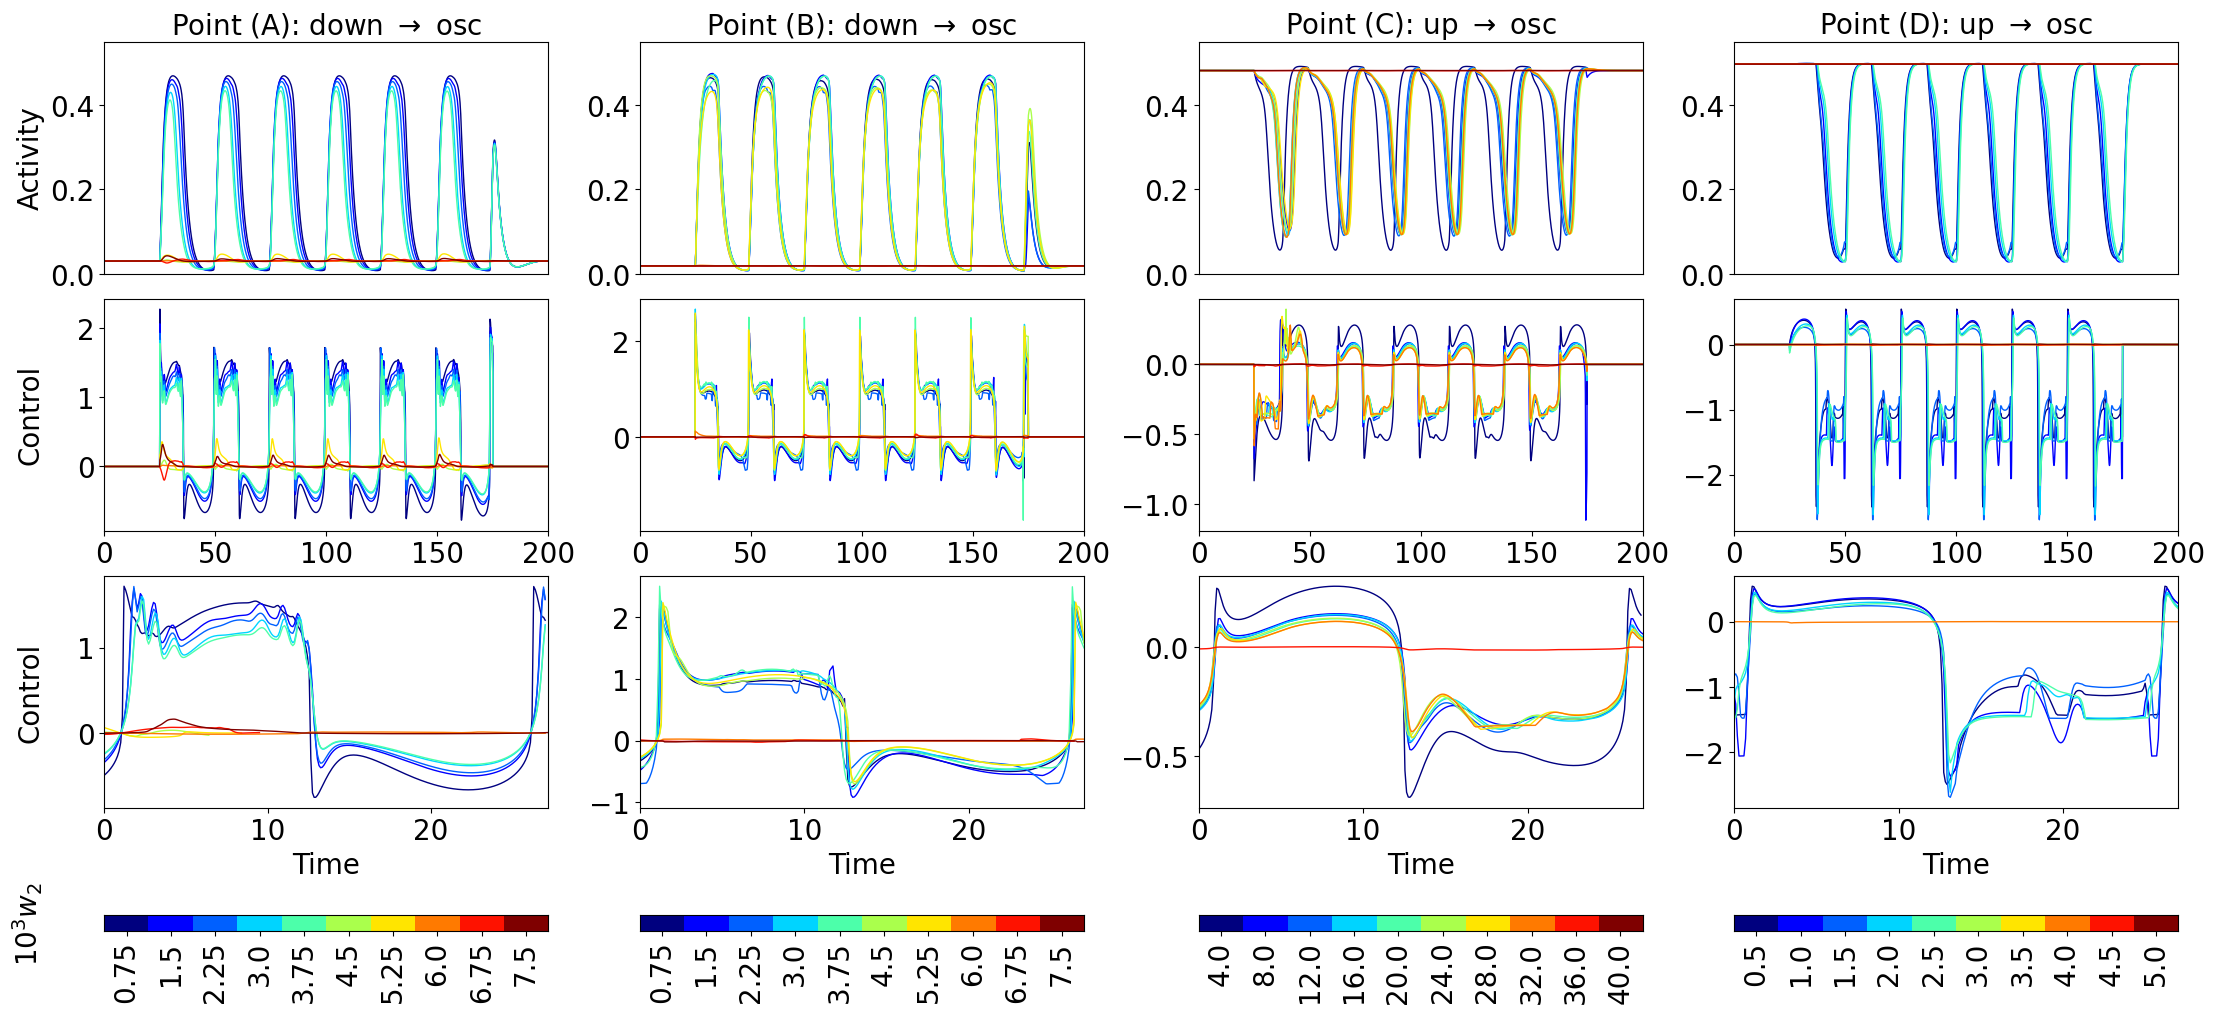

In [20]:
indzoom = np.zeros((len(p_names), len(w2_array_list[0])))
indzoom[0,:] = 6
indzoom[1,:] = 6
indzoom[2,:] = 5
indzoom[3,:] = 5

plot_1n_osc([ data["A"]["state"], data["B"]["state"], data["C"]["state"], data["D"]["state"] ],
            [ data["A"]["control"], data["B"]["control"], data["C"]["control"], data["D"]["control"] ],
            duration, model.params.dt,
            [ data["A"]["w2"], data["B"]["w2"], data["C"]["w2"], data["D"]["w2"], ],
            indzoom,
            os.path.join(dir, "WC_w2.pdf")
            )

In [135]:
with open(os.path.join(pickledir, 'osc_1n_wc.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [5]:
with open(os.path.join(pickledir, 'osc_1n_wc.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['A', 'B', 'C', 'D'])


In [6]:
data_noisy = dict()
sigma_array = [1e-2, 5*1e-2, 1e-1]
M = 100
w2_n = 4

for i in range(len(p_names)):
    p = p_names[i]
    if p != "D": continue
    data_noisy = dict()
    data_noisy["coordinates"] = coords[i]
    data_noisy["target_period"] = 25.
    data_noisy["control"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy["state"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy["cost"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy["w2"] = np.array([4. * 1e-5, 6. * 1e-5, 8. * 1e-5, 1e-4])


    data_noisy["control_det"] = data[p]["control"][1].copy()
    data_noisy["cost_det"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy["state_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy["control_det_opt"] = [[data[p]["control"][1].copy() for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy["cost_det_opt"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy["state_det_opt"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy["state_det_opt_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

In [7]:
it = 100

p = data_noisy["coordinates"]
testd = 1000.
pr = np.arange(0,1001,100)

target_period = data_noisy["target_period"]
int0 = 250
int1 = int0 + int(target_period/dt)*6



In [36]:
wind = 0

for si in range(len(sigma_array)):
    
    print("SIGMA = ", sigma_array[si])
    w2 = data_noisy["w2"][wind]

    model.params.sigma_ou = sigma_array[si]

    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    model.params["exc_ext_baseline"] = p[0]
    model.params["inh_ext_baseline"] = p[1]
    model.params["exc_ext"] = test_input
    model.params["inh_ext"] = test_input
    model.run()

    einit = np.zeros((N, 1))
    iinit = np.zeros((N, 1))
    for n in range(N):
        einit[n,:] = np.mean(model.exc[n,1000:])
        iinit[n,:] = np.mean(model.inh[n,1000:])

    model.params.duration = duration
    
    model.params["exc_init"] = einit
    model.params["inh_init"] = iinit
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]
    model.run()

    if False:
        plt.plot(model.exc[0,:])
        plt.show()

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                    M=M,
                                    M_validation=M*10,
                                    validate_per_step=False,
    )
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(data_noisy["control"][wind][si]) != type(None):
            model_controlled.control = data_noisy["control"][wind][si].copy()
            model_controlled.update_input()

    if True:
        for l in range(2):
            for k in range(-8,9,2):
                model_controlled.step = 10.**k
                model_controlled.optimize(it)
                model_controlled.zero_step_encountered = False

        data_noisy["control"][wind][si] = model_controlled.control.copy()
        data_noisy["cost"][wind][si] = model_controlled.cost_validation

        meanstate = model_controlled.get_xs()
        for m in range(M-1):
            model_controlled.model.run()
            meanstate += model_controlled.get_xs()
        data_noisy["state"][wind][si] = meanstate / M
    
    #################################################
    data_noisy["cost_det"][wind][si], data_noisy["state_det"][wind][si] = get_noisy_cost(data_noisy["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
    print("cost det = ", data_noisy["cost_det"][wind][si])

    #################################################

    if True:

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                        M=M,
                                        M_validation=M*10,
                                        validate_per_step=False,
        )

        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.
        model_controlled.maximum_control_strength = maxstr

        model_controlled.control = data_noisy["control_det"].copy()

        if True:
            if type(data_noisy["control_det_opt"][wind][si]) != type(None):
                model_controlled.control = data_noisy["control_det_opt"][wind][si].copy()
        
        model_controlled.update_input()
        
        for l in range(2):
            for k in range(-8,9,2):
                model_controlled.step = 10.**k
                model_controlled.optimize(it)
                model_controlled.zero_step_encountered = False

        data_noisy["control_det_opt"][wind][si] = model_controlled.control.copy()
        data_noisy["cost_det_opt"][wind][si] = model_controlled.cost_validation

        model_controlled.update_input()

        meanstate = model_controlled.get_xs()
        for m in range(M-1):
            model_controlled.model.run()
            meanstate += model_controlled.get_xs()
        data_noisy["state_det_opt"][wind][si] = meanstate / M
        plt.show()

    if True:
        model.params.sigma_ou = 0.
        model.params.duration = testd
        model.params["exc_ext_baseline"] = p[0]
        model.params["inh_ext_baseline"] = p[1]
        model.run()

        einit = np.zeros((N, 1))
        iinit = np.zeros((N, 1))
        for n in range(N):
            einit[n,:] = model.exc[n,-1]
            iinit[n,:] = model.inh[n,-1]

        model.params.duration = duration
   
        model.params["exc_ext"] = data_noisy["control_det_opt"][wind][si][:,0,:]
        model.params["inh_ext"] = data_noisy["control_det_opt"][wind][si][:,1,:]
        model.params["exc_init"] = einit
        model.params["inh_init"] = iinit

        model.run()
        data_noisy["state_det_opt_det"][wind][si] = get_xs(model)

    with open(os.path.join(pickledir, 'osc_1n_wc_noisy.pickle'), 'wb') as f:
        pickle.dump(data_noisy, f)

SIGMA =  0.01
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -0.002385312923144309
Mean cost in iteration 100: -0.0025784752192043584
Minimal cost found at iteration 71
Final cost validated with 1000 noise realizations : -0.0023079345996897733
Compute control for a noisy system
Mean cost in iteration 0: -0.002521308095649609
Mean cost in iteration 100: -0.002128757044247573
Minimal cost found at iteration 122
Final cost validated with 1000 noise realizations : -0.0023813444801336937
Compute control for a noisy system
Mean cost in iteration 0: -0.00244192263463658
Mean cost in iteration 100: -0.002194056565012661
Minimal cost found at iteration 122
Final cost validated with 1000 noise realizations : -0.002352486893465468
Compute control for a noisy system
Mean cost in iteration 0: -0.002380545560106971
Mean cost in iteration 100: -0.0023813894127009856
Minimal cost found at iteration 396
Final cost validated with 1000 noise re

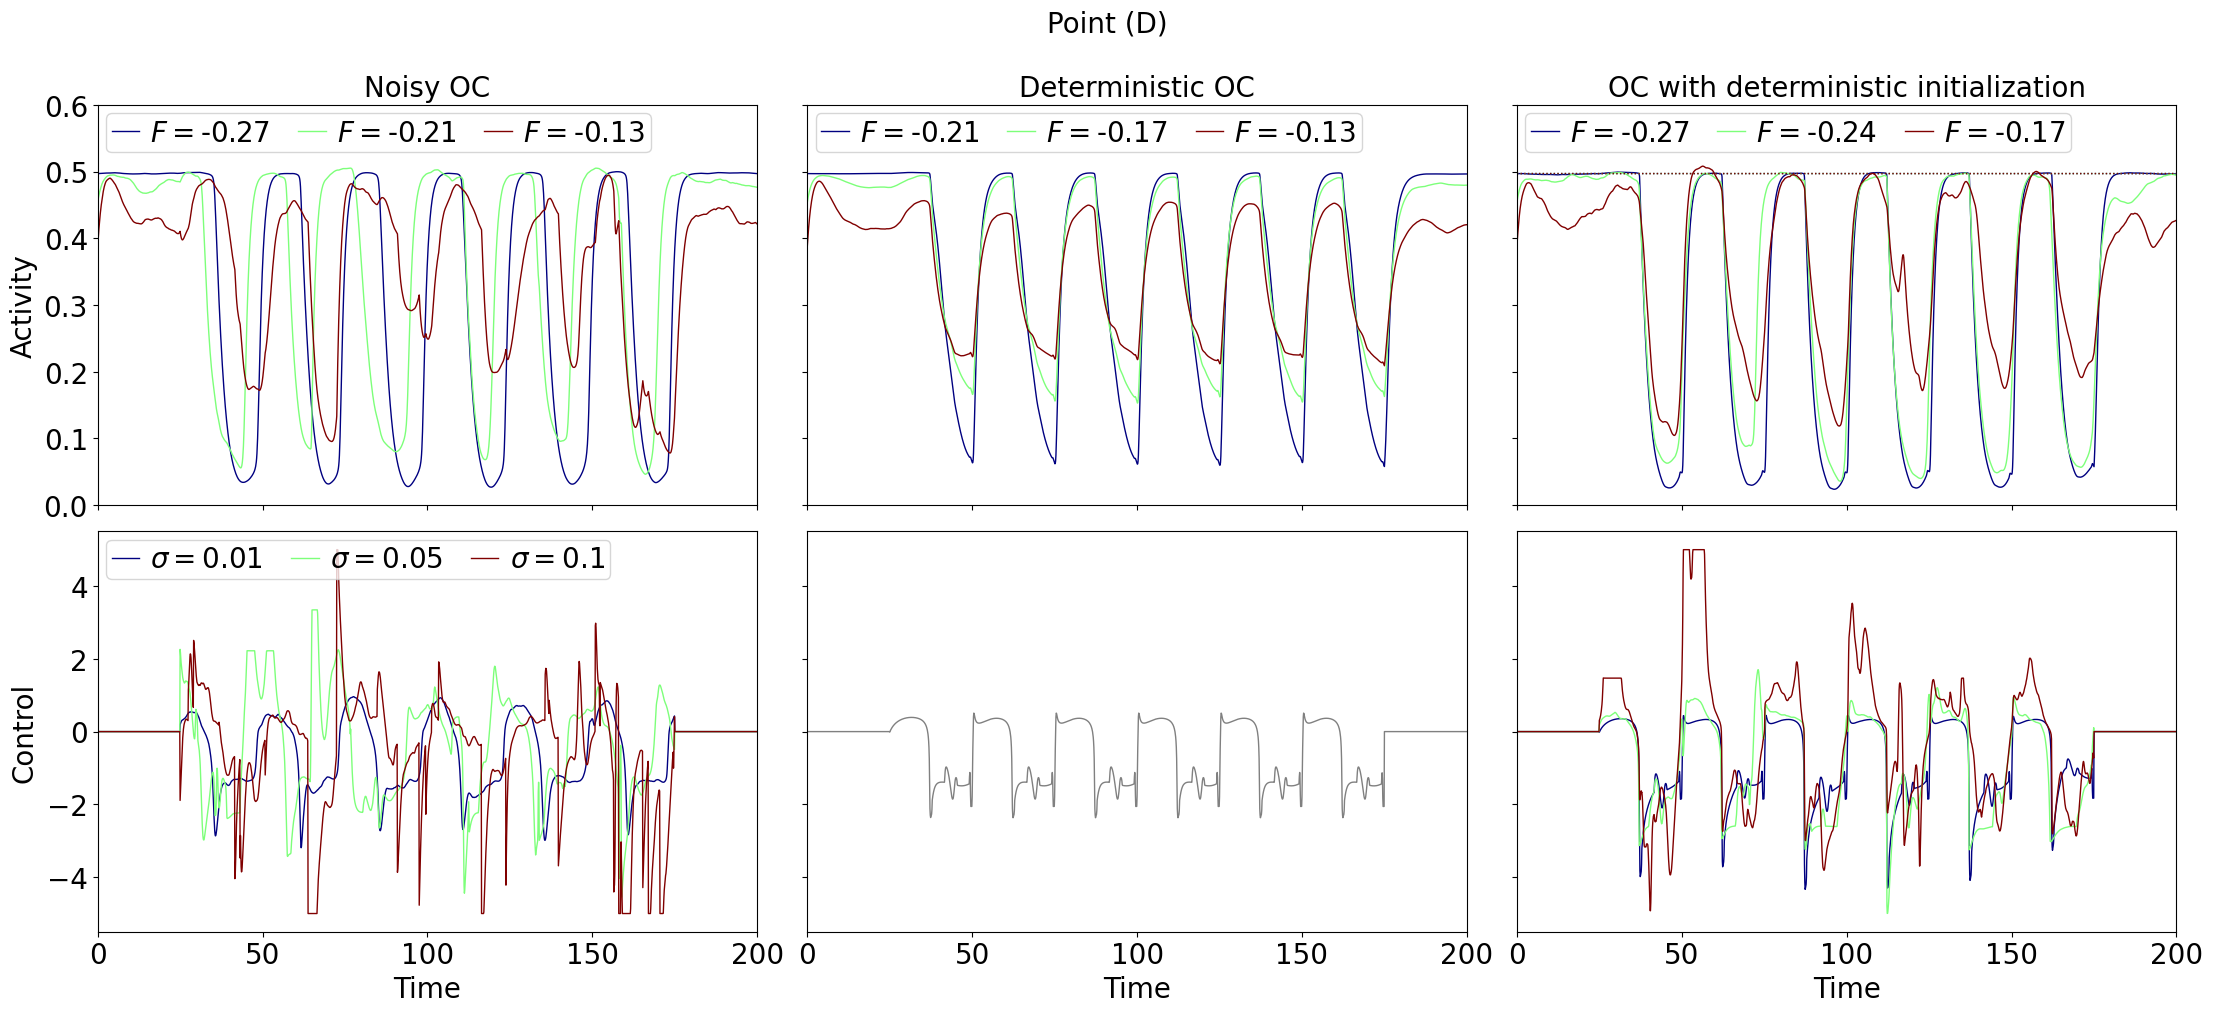

-0.267 & -0.205 & -0.13 & -0.213 & -0.168 & -0.13 & -0.269 & -0.244 & -0.171 \\


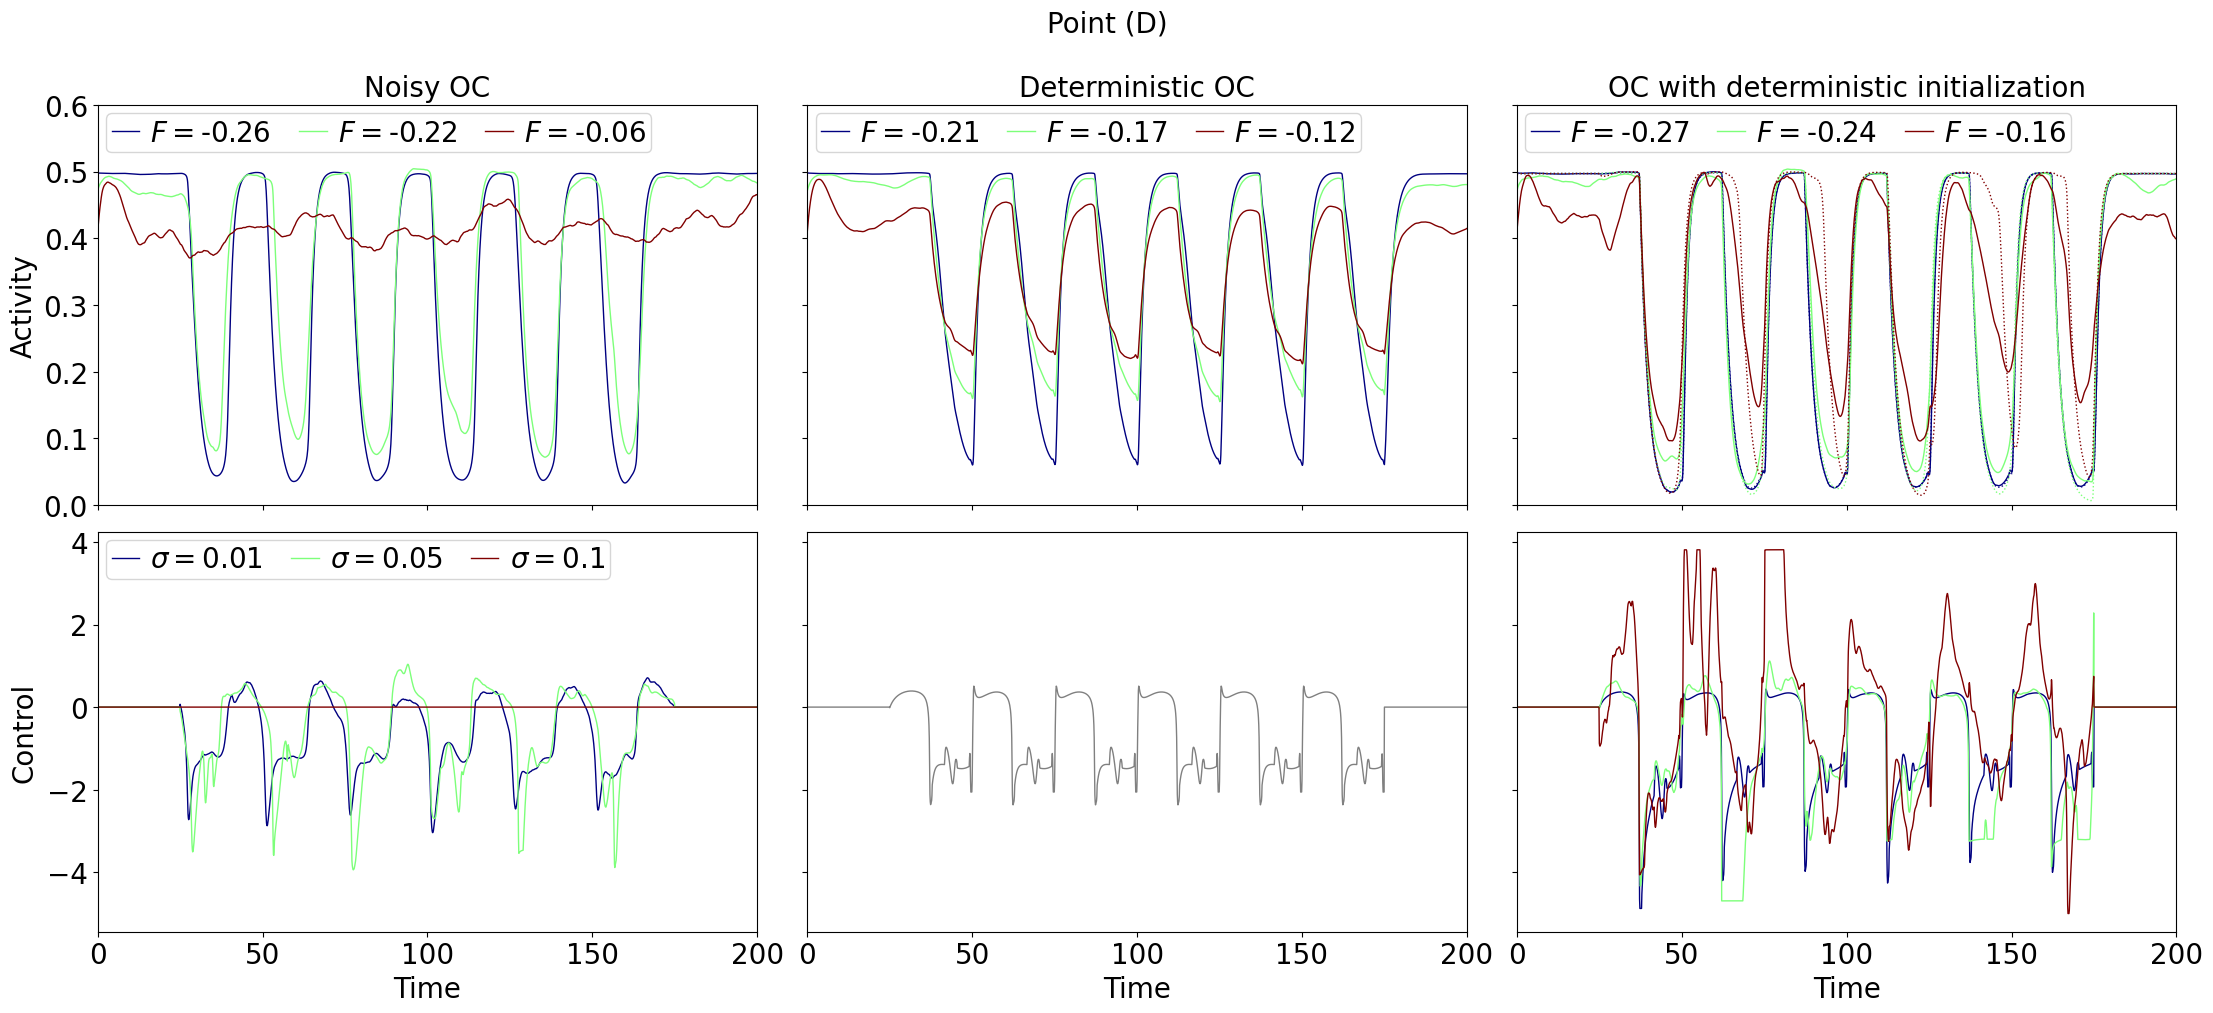

-0.26 & -0.219 & -0.059 & -0.212 & -0.166 & -0.124 & -0.266 & -0.242 & -0.156 \\


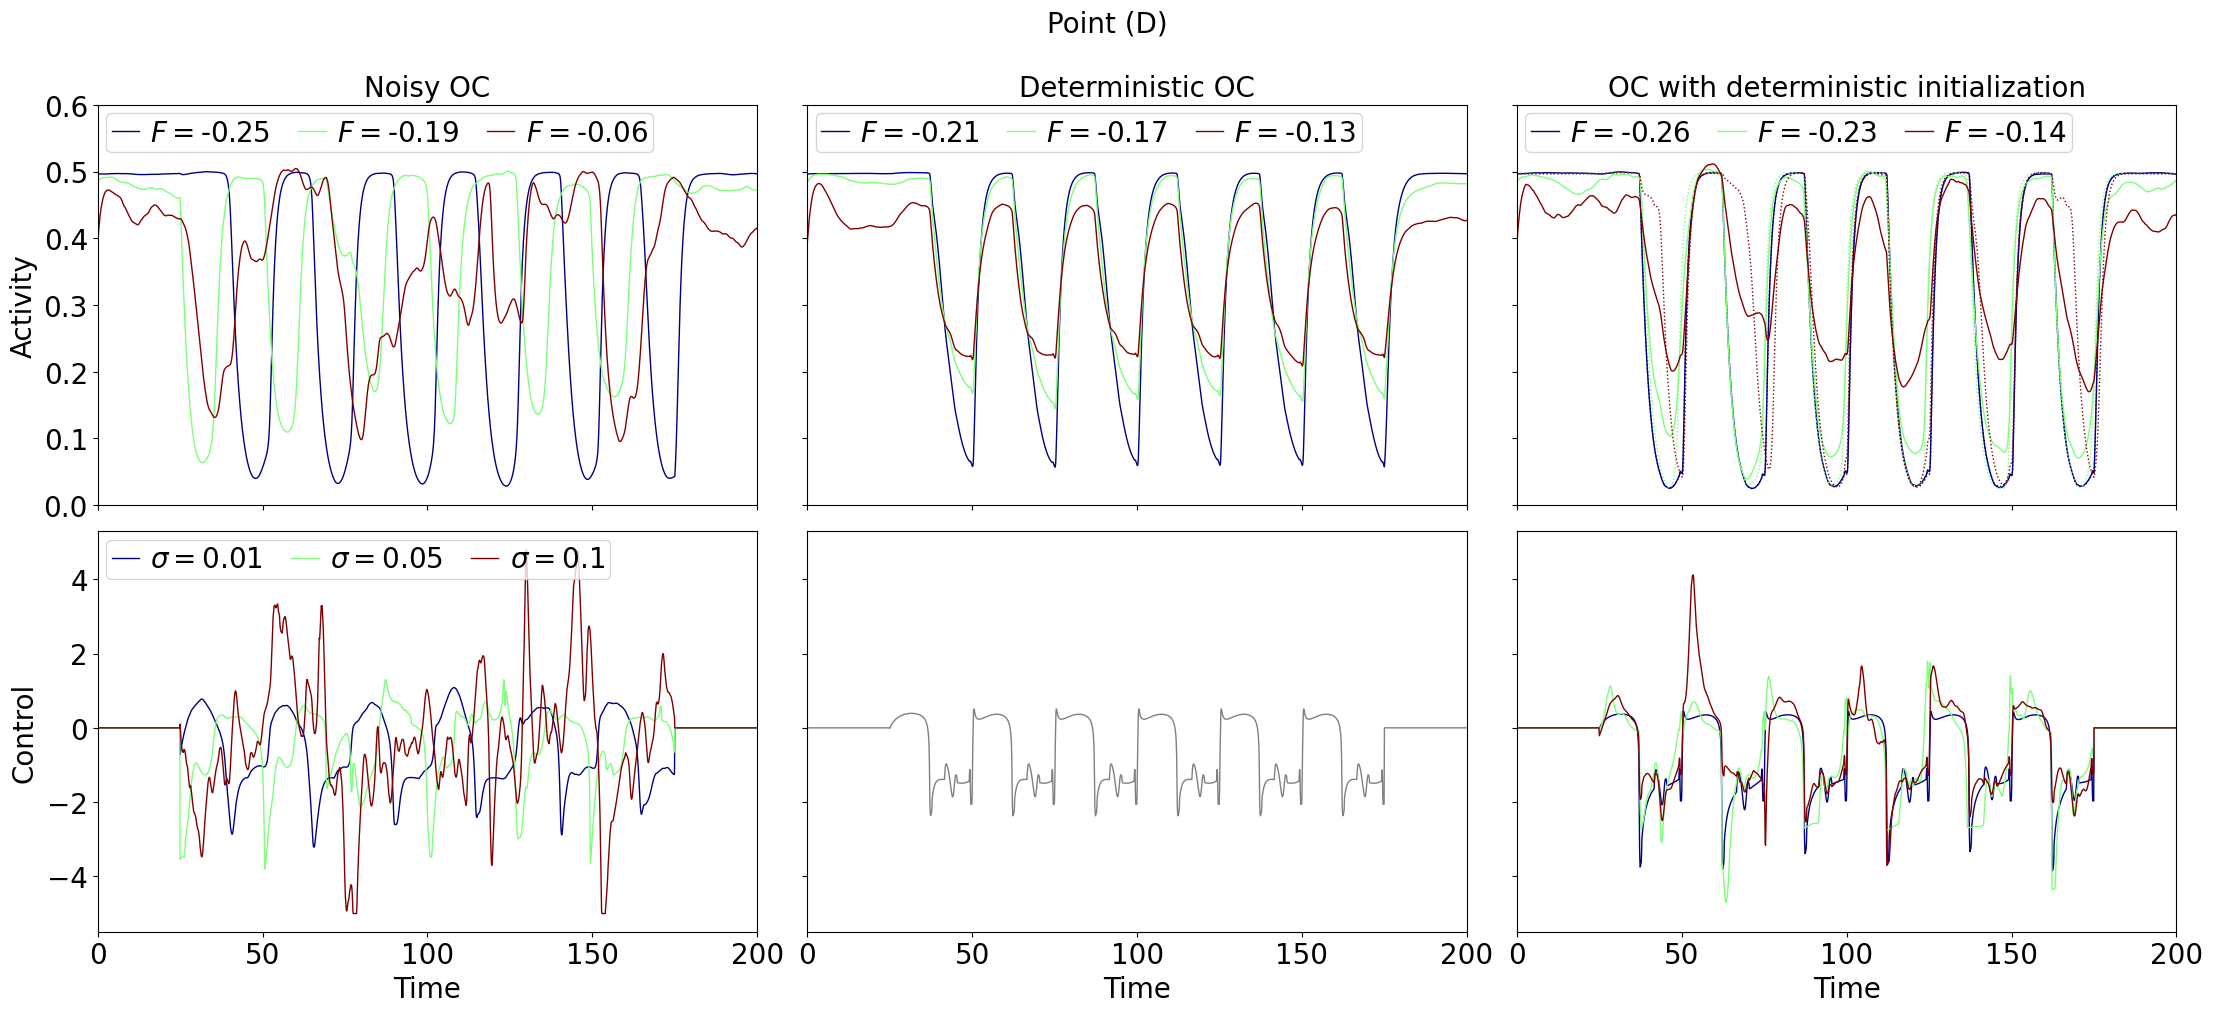

-0.248 & -0.186 & -0.064 & -0.211 & -0.166 & -0.126 & -0.264 & -0.229 & -0.137 \\


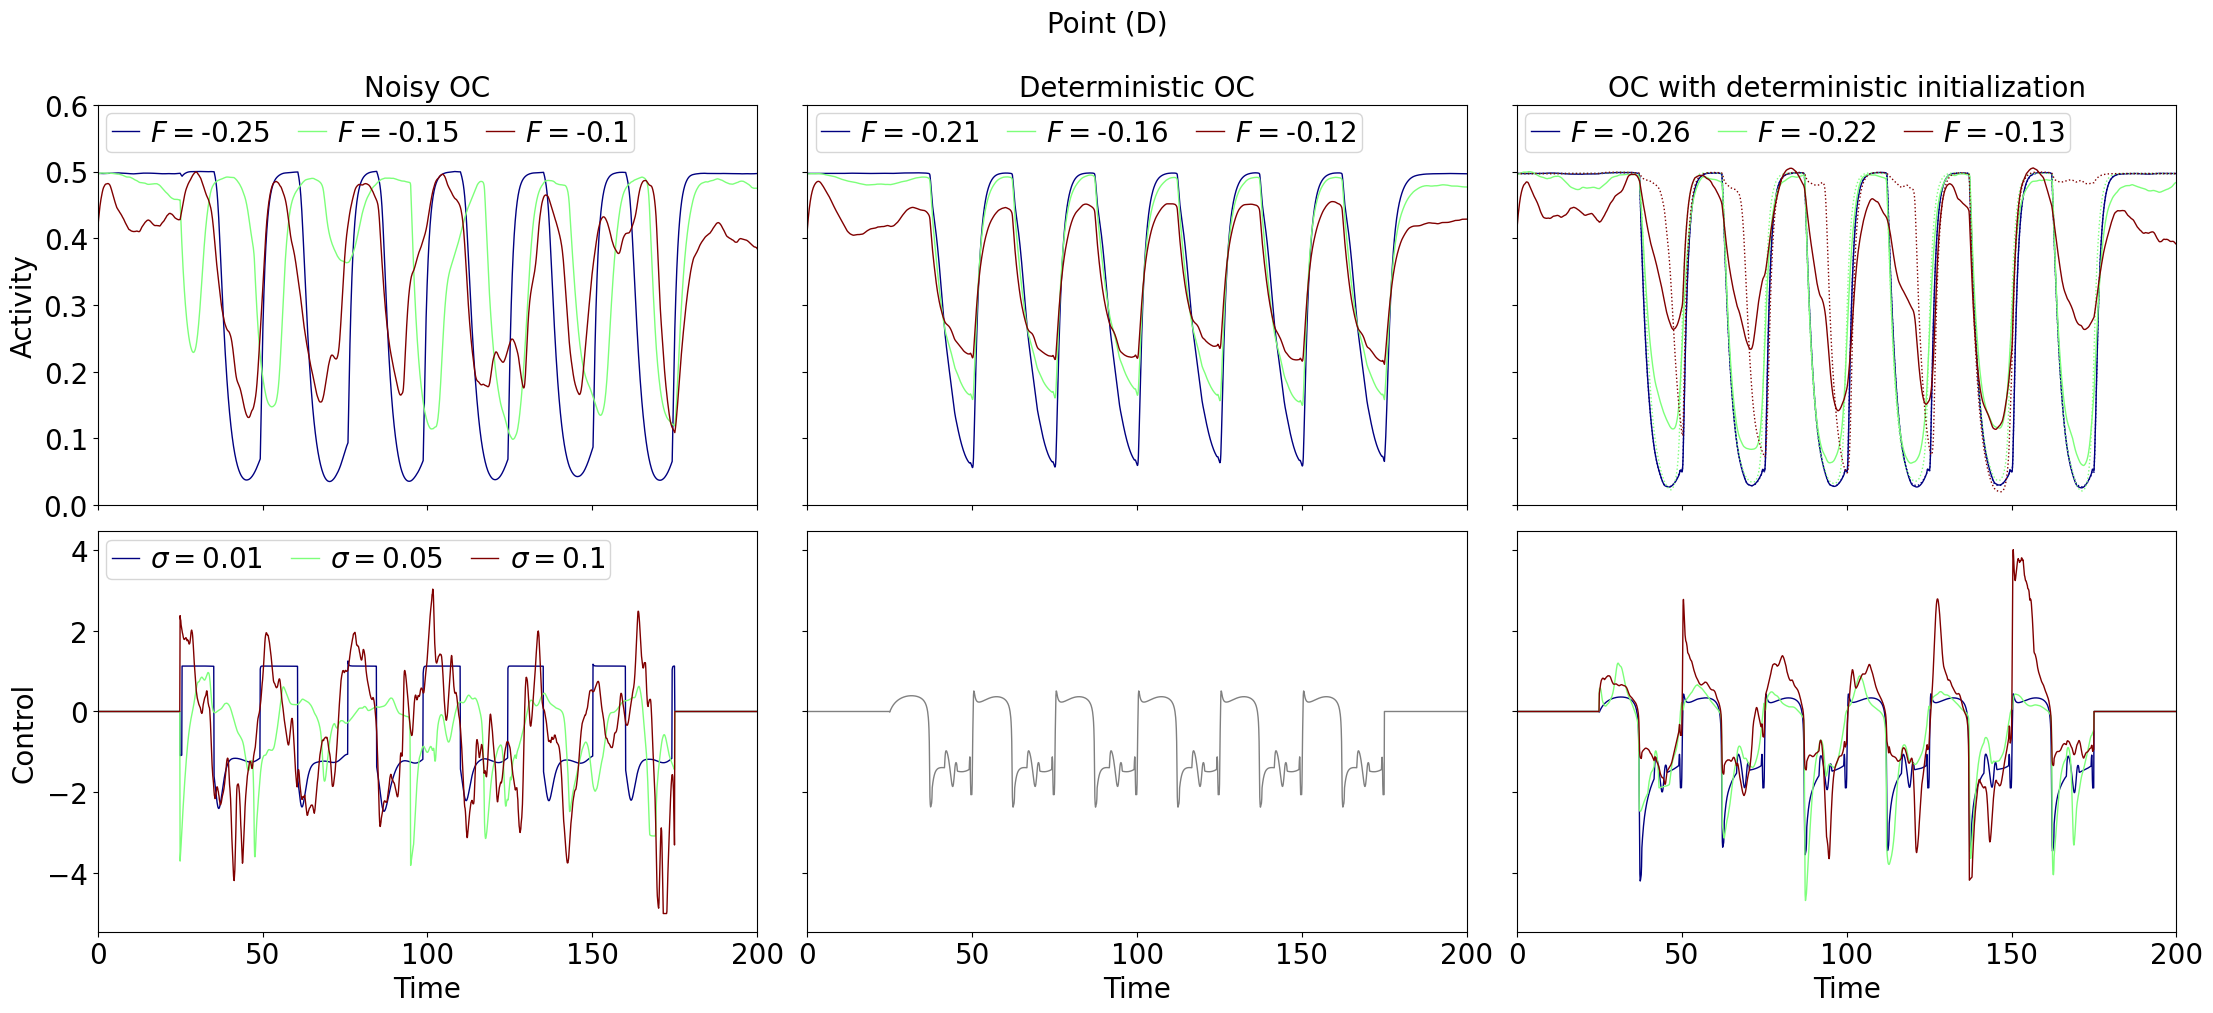

-0.252 & -0.153 & -0.103 & -0.209 & -0.164 & -0.124 & -0.261 & -0.219 & -0.128 \\


In [33]:
for wind in range(w2_n):

        plot_1n_osc_noisy(
                data_noisy["state"][wind], data_noisy["control"][wind], data_noisy["cost"][wind],
                data_noisy["state_det"][wind], data_noisy["control_det"], data_noisy["cost_det"][wind],
                data_noisy["state_det_opt"][wind], data_noisy["control_det_opt"][wind], data_noisy["cost_det_opt"][wind],
                data["D"]["state"][1], data_noisy["state_det_opt_det"][wind],
                duration, dt, sigma_array,  M, os.path.join(dir, "WC_w2_noisy" + str(wind) + ".pdf"))

        tablestring = ""
        for si in range(len(sigma_array)):
                tablestring = tablestring + str(np.around(data_noisy["cost"][wind][si],3)) + " & "
        for si in range(len(sigma_array)):
                tablestring = tablestring + str(np.around(data_noisy["cost_det"][wind][si],3)) + " & "
        for si in range(len(sigma_array)):
                tablestring = tablestring + str(np.around(data_noisy["cost_det_opt"][wind][si],3)) + " & "
        tablestring = tablestring[:-3]
        tablestring = tablestring + " \\" + "\\"

        print(tablestring)

In [15]:
data_noisy["control"][1] = data_noisy["control"][0].copy()
data_noisy["control"][2] = data_noisy["control"][0].copy()
data_noisy["control"][3] = data_noisy["control"][0].copy()

In [41]:
it = 100

for wind in range(1, w2_n):

    if wind != 3: continue
    
    for si in range(len(sigma_array)):
        print("SIGMA = ", sigma_array[si])
        w2 = data_noisy["w2"][wind]

        model.params.sigma_ou = sigma_array[si]

        model.params.duration = testd
        model.params["exc_ext"] = test_input
        model.params["inh_ext"] = test_input
        model.params["exc_ext_baseline"] = p[0]
        model.params["inh_ext_baseline"] = p[1]
        model.run()

        einit = np.zeros((N, 1))
        iinit = np.zeros((N, 1))
        for n in range(N):
            einit[n,:] = np.mean(model.exc[n,1000:])
            iinit[n,:] = np.mean(model.inh[n,1000:])

        model.params.duration = duration
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]
        model.params["exc_init"] = einit
        model.params["inh_init"] = iinit
        model.run()

        if False:
            plt.plot(model.exc[0,:])
            plt.show()

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                        M=M,
                                        M_validation=M*10,
                                        validate_per_step=False,
        )
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data_noisy["control"][wind][si]) != type(None):
                model_controlled.control = data_noisy["control"][wind][si].copy()
                model_controlled.update_input()

        if True:
            for l in range(2):
                for k in range(-8,9,2):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy["control"][wind][si] = model_controlled.control.copy()
            data_noisy["cost"][wind][si] = model_controlled.cost_validation

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                model_controlled.model.run()
                meanstate += model_controlled.get_xs()
            data_noisy["state"][wind][si] = meanstate / M
        
        #################################################

        data_noisy["cost_det"][wind][si], data_noisy["state_det"][wind][si] = get_noisy_cost(data_noisy["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
        print("cost det = ", data_noisy["cost_det"][wind][si])

        #################################################

        if True:

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                            M=M,
                                            M_validation=M*10,
                                            validate_per_step=False,
            )

            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f"] = 1.
            model_controlled.maximum_control_strength = maxstr

            model_controlled.control = data_noisy["control_det"].copy()

            if True:
                if type(data_noisy["control_det_opt"][wind][si]) != type(None):
                    model_controlled.control = data_noisy["control_det_opt"][wind][si].copy()
            
            model_controlled.update_input()
            
            for l in range(2):
                for k in range(-8,9,2):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy["control_det_opt"][wind][si] = model_controlled.control.copy()
            data_noisy["cost_det_opt"][wind][si] = model_controlled.cost_validation

            model_controlled.update_input()

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                model_controlled.model.run()
                meanstate += model_controlled.get_xs()
            data_noisy["state_det_opt"][wind][si] = meanstate / M

        if True:
            model.params.sigma_ou = 0.
            model.params.duration = testd
            model.params["exc_ext"] = test_input
            model.params["inh_ext"] = test_input
            model.params["exc_ext_baseline"] = p[0]
            model.params["inh_ext_baseline"] = p[1]
            model.run()

            einit = np.zeros((N, 1))
            iinit = np.zeros((N, 1))
            for n in range(N):
                einit[n,:] = model.exc[n,-1]
                iinit[n,:] = model.inh[n,-1]

            model.params.duration = duration
    
            model.params["exc_ext"] = data_noisy["control_det_opt"][wind][si][:,0,:]
            model.params["inh_ext"] = data_noisy["control_det_opt"][wind][si][:,1,:]
            model.params["exc_init"] = einit
            model.params["inh_init"] = iinit

            model.run()
            data_noisy["state_det_opt_det"][wind][si] = get_xs(model)

        with open(os.path.join(pickledir, 'osc_1n_wc_noisy.pickle'), 'wb') as f:
            pickle.dump(data_noisy, f)

SIGMA =  0.01
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -0.0024731866053257375
Mean cost in iteration 100: -0.0024577752258593817
Minimal cost found at iteration 88
Final cost validated with 1000 noise realizations : -0.0023632260369829154
Compute control for a noisy system
Mean cost in iteration 0: -0.0025490985153815097
Mean cost in iteration 100: -0.002489280756252308
Minimal cost found at iteration 88
Final cost validated with 1000 noise realizations : -0.0023713324968187757
Compute control for a noisy system
Mean cost in iteration 0: -0.0025382483332621604
Mean cost in iteration 100: -0.0022819491846605873
Minimal cost found at iteration 264
Final cost validated with 1000 noise realizations : -0.0023928335788107953
Compute control for a noisy system
Mean cost in iteration 0: -0.002379421154372611
Mean cost in iteration 100: -0.0025479018214836853
Minimal cost found at iteration 360
Final cost validated with 1000 noi

In [9]:
def get_noisy_cost(control, M, sigma, wf, w2):

    mod = copy.deepcopy(model)

    mod.params.sigma_ou = sigma
    mod.params["exc_ext"] = control[:,0,:]
    mod.params["inh_ext"] = control[:,1,:]
    
    mod.run()
    state = get_xs(mod)
    cost_f = wf * np.sum(cost_functions.fourier_cost(state, dt, data_noisy["target_period"], costmat, [int0, int1]))
    cost_2 = w2 * np.sum(cost_functions.L2_cost(control))*dt

    for m in range(1,10*M):
        mod.run()
        state_add = get_xs(mod)
        cost_f_add = wf * np.sum(cost_functions.fourier_cost(state_add, dt, data_noisy["target_period"], costmat, [int0, int1]))

        cost_f += cost_f_add
        state += state_add

    print(cost_2, cost_f/(10*M))

    return cost_2 + cost_f/(10*M), state/(10*M)

def get_xs(m):

    xs_begin = np.concatenate((m.params["exc_init"], m.params["inh_init"]), axis=1)[
        :, :, np.newaxis
    ]
    xs = np.concatenate(
        (
            xs_begin,
            np.stack((m.exc, m.inh), axis=1),
        ),
        axis=2,
    )

    return xs

In [8]:
with open(os.path.join(pickledir, 'osc_1n_wc_noisy.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data_noisy = res_read.copy()

dict_keys(['coordinates', 'target_period', 'control', 'state', 'cost', 'w2', 'control_det', 'cost_det', 'state_det', 'control_det_opt', 'cost_det_opt', 'state_det_opt', 'state_det_opt_det'])


In [10]:
data_noisy_10 = dict()
M = 10

for i in range(len(p_names)):
    p = p_names[i]
    if p != "D": continue
    data_noisy_10 = dict()
    data_noisy_10["coordinates"] = coords[i]
    data_noisy_10["target_period"] = 25.
    data_noisy_10["control"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_10["state"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_10["cost"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_10["w2"] = np.array([4. * 1e-5, 6. * 1e-5, 8. * 1e-5, 1e-4])


    data_noisy_10["control_det"] = data[p]["control"][1].copy()
    data_noisy_10["cost_det"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_10["state_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_10["control_det_opt"] = [[data[p]["control"][1].copy() for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_10["cost_det_opt"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_10["state_det_opt"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_10["state_det_opt_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

it = 100

p = data_noisy["coordinates"]
testd = 1000.
pr = np.arange(0,1001,100)

target_period = data_noisy_10["target_period"]
int0 = 250
int1 = int0 + int(target_period/dt)*6
test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)

In [14]:
for wind in range(w2_n):

    #if wind != 3: continue
    
    for si in range(len(sigma_array)):
        print("SIGMA = ", sigma_array[si])
        w2 = data_noisy_10["w2"][wind]

        model.params.sigma_ou = sigma_array[si]

        model.params.duration = testd
        model.params["exc_ext"] = test_input
        model.params["inh_ext"] = test_input
        model.params["exc_ext_baseline"] = p[0]
        model.params["inh_ext_baseline"] = p[1]
        model.run()

        einit = np.zeros((N, 1))
        iinit = np.zeros((N, 1))
        for n in range(N):
            einit[n,:] = np.mean(model.exc[n,1000:])
            iinit[n,:] = np.mean(model.inh[n,1000:])

        model.params.duration = duration
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]
        model.params["exc_init"] = einit
        model.params["inh_init"] = iinit
        model.run()

        if False:
            plt.plot(model.exc[0,:])
            plt.show()

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                        M=M,
                                        M_validation=M*10,
                                        validate_per_step=False,
        )
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data_noisy_10["control"][wind][si]) != type(None):
                model_controlled.control = data_noisy_10["control"][wind][si].copy()
                model_controlled.update_input()

        if True:
            for l in range(2):
                for k in range(-8,9,2):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy_10["control"][wind][si] = model_controlled.control.copy()
            data_noisy_10["cost"][wind][si] = model_controlled.cost_validation

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                model_controlled.model.run()
                meanstate += model_controlled.get_xs()
            data_noisy_10["state"][wind][si] = meanstate / M
        
        #################################################

        data_noisy_10["cost_det"][wind][si], data_noisy_10["state_det"][wind][si] = get_noisy_cost(data_noisy_10["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
        print("cost det = ", data_noisy_10["cost_det"][wind][si])

        #################################################

        if True:

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                            M=M,
                                            M_validation=M*10,
                                            validate_per_step=False,
            )

            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f"] = 1.
            model_controlled.maximum_control_strength = maxstr

            model_controlled.control = data_noisy_10["control_det"].copy()

            if True:
                if type(data_noisy_10["control_det_opt"][wind][si]) != type(None):
                    model_controlled.control = data_noisy_10["control_det_opt"][wind][si].copy()
            
            model_controlled.update_input()
            
            for l in range(2):
                for k in range(-8,9,2):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy_10["control_det_opt"][wind][si] = model_controlled.control.copy()
            data_noisy_10["cost_det_opt"][wind][si] = model_controlled.cost_validation

            model_controlled.update_input()

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                model_controlled.model.run()
                meanstate += model_controlled.get_xs()
            data_noisy_10["state_det_opt"][wind][si] = meanstate / M

        if True:
            model.params.sigma_ou = 0.
            model.params.duration = testd
            model.params["exc_ext"] = test_input
            model.params["inh_ext"] = test_input
            model.params["exc_ext_baseline"] = p[0]
            model.params["inh_ext_baseline"] = p[1]
            model.run()

            einit = np.zeros((N, 1))
            iinit = np.zeros((N, 1))
            for n in range(N):
                einit[n,:] = model.exc[n,-1]
                iinit[n,:] = model.inh[n,-1]

            model.params.duration = duration
    
            model.params["exc_ext"] = data_noisy["control_det_opt"][wind][si][:,0,:]
            model.params["inh_ext"] = data_noisy["control_det_opt"][wind][si][:,1,:]
            model.params["exc_init"] = einit
            model.params["inh_init"] = iinit

            model.run()
            data_noisy["state_det_opt_det"][wind][si] = get_xs(model)

        with open(os.path.join(pickledir, 'osc_1n_wc_noisy_10.pickle'), 'wb') as f:
            pickle.dump(data_noisy_10, f)

SIGMA =  0.01
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -0.002590132940713681
Mean cost in iteration 100: -0.002189324635845717
Minimal cost found at iteration 82
Final cost validated with 100 noise realizations : -0.002223381753293418
Compute control for a noisy system
Mean cost in iteration 0: -0.0024867460570799143
Mean cost in iteration 100: -0.0020683262743718374
Minimal cost found at iteration 178
Final cost validated with 100 noise realizations : -0.002440608162981198
Compute control for a noisy system
Mean cost in iteration 0: -0.002283463761575827
Mean cost in iteration 100: -0.0020266753935844635
Minimal cost found at iteration 243
Final cost validated with 100 noise realizations : -0.002354281407735452
Compute control for a noisy system
Mean cost in iteration 0: -0.002425748748589212
Mean cost in iteration 100: -0.002227673828947061
Minimal cost found at iteration 243
Final cost validated with 100 noise realiz

/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'interval' of function 'fourier_cost'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "neurolib/neurolib/control/optimal_control/cost_functions.py", line 194:
@numba.njit
def fourier_cost(data, dt, target_period, cost_matrix, interval):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


0.003802529388372033 -0.22058346339403012
cost det =  -0.2167809340056581
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -0.21257620359947388
Mean cost in iteration 100: -0.21018584213890895
Minimal cost found at iteration 85
Final cost validated with 100 noise realizations : -0.2176017964200898
Compute control for a noisy system
Mean cost in iteration 0: -0.21985353000930924
Mean cost in iteration 100: -0.2072741502202744
Minimal cost found at iteration 168
Final cost validated with 100 noise realizations : -0.21377291229429624
Compute control for a noisy system
Mean cost in iteration 0: -0.21013091833819142
Mean cost in iteration 100: -0.21657383952976833
Minimal cost found at iteration 270
Final cost validated with 100 noise realizations : -0.21182197652285986
Compute control for a noisy system
Mean cost in iteration 0: -0.20915430314705646
Mean cost in iteration 100: -0.22415510157911706
Minimal cost found at iteration 27

In [17]:
for wind in range(w2_n):

    tablestring = ""
    tablestring = tablestring + str(data_noisy_10["w2"][wind]) + " & "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_10["cost"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_10["cost_det"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_10["cost_det_opt"][wind][si],3)) + " & "
    tablestring = tablestring[:-3]
    tablestring = tablestring + " \\" + "\\"

    print(tablestring)

4e-05 & -0.255 & -0.216 & -0.146 & \hspace{10pt} -0.217 & -0.167 & -0.133 & \hspace{10pt} -0.267 & -0.2 & -0.162 \\
6.000000000000001e-05 & -0.253 & -0.138 & -0.083 & \hspace{10pt} -0.213 & -0.172 & -0.124 & \hspace{10pt} -0.264 & -0.226 & -0.127 \\
8e-05 & -0.244 & -0.12 & -0.063 & \hspace{10pt} -0.211 & -0.167 & -0.125 & \hspace{10pt} -0.26 & -0.179 & -0.123 \\
0.0001 & -0.24 & -0.115 & -0.059 & \hspace{10pt} -0.204 & -0.16 & -0.112 & \hspace{10pt} -0.26 & -0.202 & -0.126 \\


In [21]:
data_noisy_30 = dict()
M = 30

for i in range(len(p_names)):
    p = p_names[i]
    if p != "D": continue
    data_noisy_30 = dict()
    data_noisy_30["coordinates"] = coords[i]
    data_noisy_30["target_period"] = 25.
    data_noisy_30["control"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_30["state"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_30["cost"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_30["w2"] = np.array([4. * 1e-5, 6. * 1e-5, 8. * 1e-5, 1e-4])


    data_noisy_30["control_det"] = data[p]["control"][1].copy()
    data_noisy_30["cost_det"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_30["state_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_30["control_det_opt"] = [[data[p]["control"][1].copy() for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_30["cost_det_opt"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_30["state_det_opt"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_30["state_det_opt_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

it = 100

p = data_noisy["coordinates"]
testd = 1000.
pr = np.arange(0,1001,100)

target_period = data_noisy_30["target_period"]
int0 = 250
int1 = int0 + int(target_period/dt)*6
test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)

In [22]:
for wind in range(w2_n):

    #if wind != 3: continue
    
    for si in range(len(sigma_array)):
        print("SIGMA = ", sigma_array[si])
        w2 = data_noisy_30["w2"][wind]

        model.params.sigma_ou = sigma_array[si]

        model.params.duration = testd
        model.params["exc_ext"] = test_input
        model.params["inh_ext"] = test_input
        model.params["exc_ext_baseline"] = p[0]
        model.params["inh_ext_baseline"] = p[1]
        model.run()

        einit = np.zeros((N, 1))
        iinit = np.zeros((N, 1))
        for n in range(N):
            einit[n,:] = np.mean(model.exc[n,1000:])
            iinit[n,:] = np.mean(model.inh[n,1000:])

        model.params.duration = duration
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]
        model.params["exc_init"] = einit
        model.params["inh_init"] = iinit
        model.run()

        if False:
            plt.plot(model.exc[0,:])
            plt.show()

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                        M=M,
                                        M_validation=M*10,
                                        validate_per_step=False,
        )
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data_noisy_30["control"][wind][si]) != type(None):
                model_controlled.control = data_noisy_30["control"][wind][si].copy()
                model_controlled.update_input()

        if True:
            for l in range(2):
                for k in range(-8,9,2):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy_30["control"][wind][si] = model_controlled.control.copy()
            data_noisy_30["cost"][wind][si] = model_controlled.cost_validation

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                model_controlled.model.run()
                meanstate += model_controlled.get_xs()
            data_noisy_30["state"][wind][si] = meanstate / M
        
        #################################################

        data_noisy_30["cost_det"][wind][si], data_noisy_30["state_det"][wind][si] = get_noisy_cost(data_noisy_30["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
        print("cost det = ", data_noisy_30["cost_det"][wind][si])

        #################################################

        if True:

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat,
                                            M=M,
                                            M_validation=M*10,
                                            validate_per_step=False,
            )

            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f"] = 1.
            model_controlled.maximum_control_strength = maxstr

            model_controlled.control = data_noisy_30["control_det"].copy()

            if True:
                if type(data_noisy_30["control_det_opt"][wind][si]) != type(None):
                    model_controlled.control = data_noisy_30["control_det_opt"][wind][si].copy()
            
            model_controlled.update_input()
            
            for l in range(2):
                for k in range(-8,9,2):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy_30["control_det_opt"][wind][si] = model_controlled.control.copy()
            data_noisy_30["cost_det_opt"][wind][si] = model_controlled.cost_validation

            model_controlled.update_input()

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                model_controlled.model.run()
                meanstate += model_controlled.get_xs()
            data_noisy_30["state_det_opt"][wind][si] = meanstate / M

        if True:
            model.params.sigma_ou = 0.
            model.params.duration = testd
            model.params["exc_ext"] = test_input
            model.params["inh_ext"] = test_input
            model.params["exc_ext_baseline"] = p[0]
            model.params["inh_ext_baseline"] = p[1]
            model.run()

            einit = np.zeros((N, 1))
            iinit = np.zeros((N, 1))
            for n in range(N):
                einit[n,:] = model.exc[n,-1]
                iinit[n,:] = model.inh[n,-1]

            model.params.duration = duration
    
            model.params["exc_ext"] = data_noisy["control_det_opt"][wind][si][:,0,:]
            model.params["inh_ext"] = data_noisy["control_det_opt"][wind][si][:,1,:]
            model.params["exc_init"] = einit
            model.params["inh_init"] = iinit

            model.run()
            data_noisy["state_det_opt_det"][wind][si] = get_xs(model)

        with open(os.path.join(pickledir, 'osc_1n_wc_noisy_30.pickle'), 'wb') as f:
            pickle.dump(data_noisy_30, f)

SIGMA =  0.01
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -0.0025912109282068396
Mean cost in iteration 100: -0.002169119530174396
Minimal cost found at iteration 26
Final cost validated with 300 noise realizations : -0.002303544966955342
Compute control for a noisy system
Mean cost in iteration 0: -0.001999475177940134
Mean cost in iteration 100: -0.0018856092017904289
Minimal cost found at iteration 26
Final cost validated with 300 noise realizations : -0.0024887282782184677
Compute control for a noisy system
Mean cost in iteration 0: -0.0021895030946466896
Mean cost in iteration 100: -0.002191117071640004
Minimal cost found at iteration 250
Final cost validated with 300 noise realizations : -0.0022835015517267067
Compute control for a noisy system
Mean cost in iteration 0: -0.002630389073591831
Mean cost in iteration 100: -0.0022034174670320303
Minimal cost found at iteration 250
Final cost validated with 300 noise real

In [23]:
for wind in range(w2_n):

    tablestring = ""
    tablestring = tablestring + str(data_noisy_30["w2"][wind]) + " & "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_30["cost"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_30["cost_det"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_30["cost_det_opt"][wind][si],3)) + " & "
    tablestring = tablestring[:-3]
    tablestring = tablestring + " \\" + "\\"

    print(tablestring)

4e-05 & -0.264 & -0.209 & -0.172 & \hspace{10pt} -0.215 & -0.167 & -0.137 & \hspace{10pt} -0.27 & -0.252 & -0.205 \\
6.000000000000001e-05 & -0.234 & -0.186 & -0.131 & \hspace{10pt} -0.21 & -0.165 & -0.128 & \hspace{10pt} -0.266 & -0.238 & -0.122 \\
8e-05 & -0.235 & -0.156 & -0.059 & \hspace{10pt} -0.212 & -0.166 & -0.13 & \hspace{10pt} -0.264 & -0.214 & -0.127 \\
0.0001 & -0.248 & -0.143 & -0.09 & \hspace{10pt} -0.207 & -0.162 & -0.121 & \hspace{10pt} -0.261 & -0.207 & -0.124 \\
